In [1]:
# !pip install autorank
# !pip install scikit_posthocs

In [1]:
import math
import warnings
import numpy as np
import pandas as pd
import scikit_posthocs as sp
from autorank import autorank
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import friedmanchisquare, sem, t
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KernelDensity, KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [3]:
warnings.filterwarnings('ignore')

In [4]:
url1 = "https://archive.ics.uci.edu/ml/machine-learning-databases/image/segmentation.data"
url2 = "https://archive.ics.uci.edu/ml/machine-learning-databases/image/segmentation.test"

In [5]:
cols = ["CLASS", "REGION-CENTROID-COL", "REGION-CENTROID-ROW", "REGION-PIXEL-COUNT", "SHORT-LINE-DENSITY-5", "SHORT-LINE-DENSITY-2", "VEDGE-MEAN", "VEDGE-SD", "HEDGE-MEAN", "HEDGE-SD", "INTENSITY-MEAN","RAWRED-MEAN","RAWBLUE-MEAN","RAWGREEN-MEAN","EXRED-MEAN","EXBLUE-MEAN","EXGREEN-MEAN","VALUE-MEAN","SATURATION-MEAN","HUE-MEAN"]

In [6]:
data1 = pd.read_csv(url1, header=2, names=cols)
data2 = pd.read_csv(url2, header=2, names=cols)
data = pd.concat([data1, data2])

In [7]:
le = LabelEncoder()

X1 = data.iloc[:, 4:9]
X2 = data.iloc[:, 10:20]
X3 = data.drop(["CLASS", "REGION-CENTROID-COL", "REGION-CENTROID-ROW", "REGION-PIXEL-COUNT"], axis=1)
data["CLASS"] = le.fit_transform(data["CLASS"])
Y = data["CLASS"]

In [8]:
X1 = (X1 - X1.mean(axis=0)) / X1.std(axis=0)
X2 = (X2 - X2.mean(axis=0)) / X2.std(axis=0)
X3 = (X3 - X3.mean(axis=0)) / X3.std(axis=0)

In [9]:
# instanciação do dataframe para o teste de Friedman
d = {
    'Bayesiano Gaussiano': [0.0] * 300,
    'k-NN': [0.0] * 300,
    'Janela de Parzen': [0.0] * 300,
    'Regressão Logística': [0.0] * 300,
}
rankings = pd.DataFrame(data=d)

# Questão 2

#### Ajuste do hiper-parâmetro k do k-NN

In [10]:
X_train = [[] for i in range(3)]
Y_train = [[] for i in range(3)]
X_test = [[] for i in range(3)]
Y_test = [[] for i in range(3)]
X_train[0], X_test[0], Y_train[0], Y_test[0] = train_test_split(X1, Y, train_size=0.8, random_state=999)
X_train[1], X_test[1], Y_train[1], Y_test[1] = train_test_split(X2, Y, train_size=0.8, random_state=999)
X_train[2], X_test[2], Y_train[2], Y_test[2] = train_test_split(X3, Y, train_size=0.8, random_state=999)

neighborhood = range(3,49,2)

Dataset  1
Melhor valor de k:  35
Acurácia com melhor k:  0.43506493506493504 

Dataset  2
Melhor valor de k:  3
Acurácia com melhor k:  0.9264069264069265 

Dataset  3
Melhor valor de k:  3
Acurácia com melhor k:  0.9177489177489178 



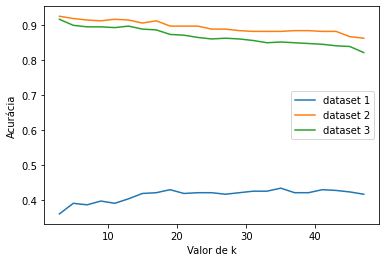

In [11]:
for i in range(3):
    acc = []
    for n in neighborhood:
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train[i], Y_train[i])
        y_pred = knn.predict(X_test[i])
        acc.append(accuracy_score(Y_test[i],y_pred))

    melhor_k = neighborhood[acc.index(max(acc))]
    print("Dataset ", i+1)
    print("Melhor valor de k: ", melhor_k)
    print("Acurácia com melhor k: ", max(acc), "\n")

    label = f"dataset {i+1}"
    plt.plot(neighborhood, acc, label=label)
    plt.xlabel('Valor de k')
    plt.ylabel('Acurácia')
plt.legend()
plt.show()

#### Ajuste do hiper-parâmetro h da Janela de Parzen

In [35]:
class BayesianParzenWindowClassifier:
  def fit(self, X, Y, h):
    self.dict_apriori = {}
    self.X = X
    self.Y = Y
    self.h = h
    self.numero_de_classes = len(Y.drop_duplicates())
    self.apriori = self.calcular_probabilidade_apriori(X, Y)
    self.dict_classes = {}
    label_classes = Y.drop_duplicates().values

    m = 0
    for label in label_classes:
      self.dict_classes[m] = label
      m = m + 1

  def calcular_probabilidade_apriori(self, X, Y):
    X['CLASSE'] = Y
    classes = Y.drop_duplicates()
    apriori = [0.0] * len(classes)

    i = 0
    for classe in classes:
      apriori[i] = len(X[X[X.columns[-1]] == classe])/len(X)
      self.dict_apriori[i] = apriori[i]
      i =  i + 1

    return apriori

  # x_k é um vetor de d-dimensoes que se deseja calcular a função, w_i é índice da classe (primeira, segunda etc.)
  def calcular_funcao_probabilidade(self, x_k, w_i):
    X = self.X 
    X['CLASSE'] = self.Y
    kde = KernelDensity(kernel="gaussian", bandwidth=self.h)
    dados_da_classe = X[X[X.columns[-1]] == self.dict_classes[w_i]].drop(['CLASSE'], axis=1)
    kde.fit(dados_da_classe)
    probabilidade = np.exp(kde.score_samples(x_k.reshape(1, -1)))

    return probabilidade

  def predict(self, x_k):
    probabilidades = [0.0] * self.numero_de_classes

    i = 0
    for classe in self.dict_classes:
      prob_condicional = self.calcular_funcao_probabilidade(x_k, classe)
      probabilidades[i] = prob_condicional * self.apriori[i]
      i = i + 1

    return probabilidades.index(max(probabilidades)), self.dict_classes[probabilidades.index(max(probabilidades))]

In [36]:
def realizar_predicoes(modelo, x_test, y_test):
  dict_acerto_e_erros = {}
  array_predicoes = [''] * len(x_test)

  x = x_test.values
  y = y_test.values

  i = 0
  for observacao in x:
    indice, valor = modelo.predict(observacao)
    if (valor == y[i]):
      dict_acerto_e_erros[i] = {"resultado": "ACERTOU", "predicao": valor, "valor_correto": y[i]}
      array_predicoes[i] = valor
    else:
      dict_acerto_e_erros[i] = {"resultado": "ERROU", "predicao": valor, "valor_correto": y[i]}
      array_predicoes[i] = valor
    
    i = i + 1

  return array_predicoes, dict_acerto_e_erros

In [37]:
X_train = [[] for i in range(3)]
Y_train = [[] for i in range(3)]
X_test = [[] for i in range(3)]
Y_test = [[] for i in range(3)]
X_train[0], X_test[0], Y_train[0], Y_test[0] = train_test_split(X1, Y, train_size=0.8, random_state=999)
X_train[1], X_test[1], Y_train[1], Y_test[1] = train_test_split(X2, Y, train_size=0.8, random_state=999)
X_train[2], X_test[2], Y_train[2], Y_test[2] = train_test_split(X3, Y, train_size=0.8, random_state=999)

hs = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095]

Dataset 1
Melhor valor de h:  0.04
Acurácia com melhor h:  0.43073593073593075 

Dataset 2
Melhor valor de h:  0.09
Acurácia com melhor h:  0.9329004329004329 

Dataset 3
Melhor valor de h:  0.095
Acurácia com melhor h:  0.9134199134199135 



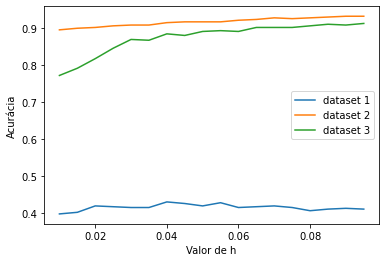

In [38]:
for i in range(3):
  acc = []
  for h in hs:
    jp = BayesianParzenWindowClassifier()
    jp.fit(X_train[i], Y_train[i], h)

    Y_pred, dict_predicoes = realizar_predicoes(jp, X_test[i], Y_test[i])

    accuracy = accuracy_score(Y_test[i], Y_pred)
    acc.append(accuracy)
  melhor_h = hs[acc.index(max(acc))]
  print(f"Dataset {i+1}")
  print("Melhor valor de h: ", melhor_h)
  print("Acurácia com melhor h: ", max(acc), "\n")

  label = f"dataset {i+1}"
  plt.plot(hs, acc, label=label)
  plt.xlabel('Valor de h')
  plt.ylabel('Acurácia')
plt.legend()
plt.show()

## k-fold

In [16]:
kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=999)
kf.get_n_splits(X3, Y)

300

## Bayesiano Gaussiano

In [24]:
class BayesianoGaussiano:

  def fit(self, X, Y):
    self.dict_medias = {}
    self.dict_variancias = {}
    self.dict_sigmas = {}
    self.dict_apriori = {}
    self.X = X
    self.Y = Y
    self.numero_de_atributos = len(X.columns)
    self.numero_de_classes = len(Y.drop_duplicates())
    self.medias, self.variancias = self.calcular_matriz_de_medias_e_matriz_de_variancia(X, Y)
    self.sigmas = self.calcular_sigmas(self.variancias)
    self.apriori = self.calcular_probabilidade_apriori(X, Y)
    self.dict_classes = {}
    label_classes = Y.drop_duplicates().values

    m = 0
    for label in label_classes:
      self.dict_classes[m] = label
      m = m + 1

  def calcular_sigmas(self, variancias):
    sigmas = {}
    i = 0

    for variancia in variancias:
      sigma = np.zeros((self.numero_de_atributos, self.numero_de_atributos), float)

      # A matriz de covariância nesse exemplo é diagonal e seus valores são dados pela variância de cada um dos atributos.
      j = 0
      for var in variancia:
        sigma[j][j] = var
        j = j + 1

      sigmas[i] = sigma
      i = i + 1

    return sigmas

  def calcular_matriz_de_medias_e_matriz_de_variancia(self, X, Y):
    classes = Y.drop_duplicates()
    matriz_medias = np.zeros((len(classes), self.numero_de_atributos))
    matriz_variancias = np.zeros((len(classes), self.numero_de_atributos))
    i = 0
    X['CLASSE'] = Y

    for classe in classes:
      X_tmp = X.loc[X['CLASSE'] == classe]
      X_tmp = X_tmp.drop(['CLASSE'], axis=1)

      j = 0
      for atributo in X_tmp.columns:
        if (atributo != 'SEQUENCE_NAME' and atributo != 'CLASSE'):
          matriz_medias[i][j] = np.mean(X_tmp[atributo])
          matriz_variancias[i][j] = np.var(X_tmp[atributo])
          j = j + 1

      self.dict_medias[classe] = matriz_medias[i]
      self.dict_variancias[classe] = matriz_variancias[i]

      i = i + 1

    return matriz_medias, matriz_variancias

  def calcular_probabilidade_apriori(self, X, Y):
    X['CLASSE'] = Y
    classes = Y.drop_duplicates()
    apriori = [0.0] * len(classes)

    i = 0
    for classe in classes:
      apriori[i] = len(X[X[X.columns[-1]] == classe])/len(X)
      self.dict_apriori[i] = apriori[i]
      i =  i + 1

    return apriori

  # x_k é um vetor de d-dimensoes que se deseja calcular a função, w_i é índice da classe (primeira, segunda etc.)
  def calcular_funcao_probabilidade(self, x_k, w_i):

    # Sigma^-1
    sigma_inv = np.linalg.pinv(self.sigmas[w_i])
    # Termo a: 2*pi^(-d/2)
    termo_a = ((2 * math.pi) ** -(self.numero_de_atributos/2))
    # Termo b: |SigmaInv|^(1/2)
    termo_b = (np.linalg.det(sigma_inv)) ** (1/2)
    # vetores
    termo_c = (x_k - self.medias[w_i])

    #escalar
    termo_d = np.dot(np.transpose(termo_c),sigma_inv)
    probabilidade = np.exp(-(1/2) * np.dot(termo_d,termo_c))

    return probabilidade

  # Método para realizar a predição de uma nova entrada
  # Parametro x_k deve representar apenas uma entrada
  def predict(self, x_k):
    probabilidades = [0.0] * self.numero_de_classes
    i = 0
    for classe in self.dict_classes:
      prob_condicional = self.calcular_funcao_probabilidade(x_k, classe)
      probabilidades[i] = prob_condicional * self.apriori[i]
      i = i + 1

    evidencia = np.sum(probabilidades)

    #retorna indice e valor
    return probabilidades.index(max(probabilidades)), self.dict_classes[probabilidades.index(max(probabilidades))]


In [25]:
bg_accuracy = []
bg_precision = []
bg_f1 = []
bg_recall = []

In [26]:
for train_id, test_id in kf.split(X3, Y):
  X1_train, X1_test = X1.iloc[train_id], X1.iloc[test_id]
  X2_train, X2_test = X2.iloc[train_id], X2.iloc[test_id]
  X3_train, X3_test = X3.iloc[train_id], X3.iloc[test_id]
  Y_train, Y_test = Y.iloc[train_id], Y.iloc[test_id]
  
  bg1 = BayesianoGaussiano()
  bg1.fit(X1_train, Y_train)

  bg2 = BayesianoGaussiano()
  bg2.fit(X2_train, Y_train)

  bg3 = BayesianoGaussiano()
  bg3.fit(X3_train, Y_train)

  Y1_pred, dict_predicoes = realizar_predicoes(bg1, X1_test, Y_test)
  Y2_pred, dict_predicoes = realizar_predicoes(bg2, X2_test, Y_test)
  Y3_pred, dict_predicoes = realizar_predicoes(bg3, X3_test, Y_test)

  votes = np.stack((Y1_pred, Y2_pred, Y3_pred), axis=-1)
  majority_vote = np.array([np.bincount(row).argmax() for row in votes])

  bg_accuracy.append(1 - accuracy_score(Y_test, majority_vote))
  bg_f1.append(f1_score(Y_test, majority_vote, average = "macro"))
  bg_precision.append(precision_score(Y_test, majority_vote, average = "macro"))
  bg_recall.append(recall_score(Y_test, majority_vote, average = "macro"))

grau_de_liberdade = len(bg_accuracy) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(bg_accuracy)
media_acuracias = np.mean(bg_accuracy)
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(bg_f1)
media_f1s = np.mean(bg_f1)
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(bg_precision)
media_precisao = np.mean(bg_precision)
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Cobertura
erro_padrao_recall = sem(bg_recall)
media_recall = np.mean(bg_recall)
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Taxa de erro: %.4f (%.4f)" % (np.mean(bg_accuracy), np.std(bg_accuracy)))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F-measure: %.4f (%.4f)" % (np.mean(bg_f1), np.std(bg_f1)))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precisão: %.4f (%.4f)" % (np.mean(bg_precision), np.std(bg_precision)))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Cobertura: %.4f (%.4f)" % (np.mean(bg_recall), np.std(bg_recall)))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings['Bayesiano Gaussiano']:
  rankings['Bayesiano Gaussiano'].iloc[ind] = bg_accuracy[ind]
  ind = ind + 1

Taxa de erro: 0.3221 (0.0236)
Intervalo de confiança:  (0.31944097706382724, 0.32480144717859705) 

F-measure: 0.6481 (0.0269)
Intervalo de confiança:  (0.6450251869408855, 0.6511543279172695) 

Precisão: 0.7635 (0.0330)
Intervalo de confiança:  (0.7597106880213434, 0.767222502899361) 

Cobertura: 0.6779 (0.0236)
Intervalo de confiança:  (0.675198552821403, 0.6805590229361728)


## k-NN

In [27]:
knn_accuracy = []
knn_precision = []
knn_f1 = []
knn_recall = []

In [28]:
for train_id, test_id in kf.split(X3, Y):
  X1_train, X1_test = X1.iloc[train_id], X1.iloc[test_id]
  X2_train, X2_test = X2.iloc[train_id], X2.iloc[test_id]
  X3_train, X3_test = X3.iloc[train_id], X3.iloc[test_id]
  Y_train, Y_test = Y.iloc[train_id], Y.iloc[test_id]

  knn1 = KNeighborsClassifier(n_neighbors=35)
  knn1.fit(X1_train, Y_train)

  knn2 = KNeighborsClassifier(n_neighbors=3)
  knn2.fit(X2_train, Y_train)

  knn3 = KNeighborsClassifier(n_neighbors=3)
  knn3.fit(X3_train, Y_train)
  
  Y1_pred = knn1.predict(X1_test)
  Y2_pred = knn2.predict(X2_test)
  Y3_pred = knn3.predict(X3_test)

  votes = np.stack((Y1_pred, Y2_pred, Y3_pred), axis=-1)
  majority_vote = np.array([np.bincount(row).argmax() for row in votes])

  knn_accuracy.append(1 - accuracy_score(Y_test, majority_vote))
  knn_precision.append(precision_score(Y_test, majority_vote, average = "macro"))
  knn_f1.append(f1_score(Y_test, majority_vote, average = "macro"))
  knn_recall.append(recall_score(Y_test, majority_vote, average = "macro"))

grau_de_liberdade = len(knn_accuracy) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(knn_accuracy)
media_acuracias = np.mean(knn_accuracy)
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(knn_f1)
media_f1s = np.mean(knn_f1)
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(knn_precision)
media_precisao = np.mean(knn_precision)
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Cobertura
erro_padrao_recall = sem(knn_recall)
media_recall = np.mean(knn_recall)
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Taxa de erro: %.4f (%.4f)" % (np.mean(knn_accuracy), np.std(knn_accuracy)))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F-measure: %.4f (%.4f)" % (np.mean(knn_f1), np.std(knn_f1[0])))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precisão: %.4f (%.4f)" % (np.mean(knn_precision), np.std(knn_precision)))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Cobertura: %.4f (%.4f)" % (np.mean(knn_recall), np.std(knn_recall)))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings['Bayesiano Gaussiano']:
  rankings['k-NN'].iloc[ind] = knn_accuracy[ind]
  ind = ind + 1

Taxa de erro: 0.0919 (0.0177)
Intervalo de confiança:  (0.08984741830299763, 0.09387552541994611) 

F-measure: 0.9069 (0.0000)
Intervalo de confiança:  (0.9048502209626867, 0.9089906562089707) 

Precisão: 0.9101 (0.0175)
Intervalo de confiança:  (0.9081472438378312, 0.9121345780726354) 

Cobertura: 0.9081 (0.0177)
Intervalo de confiança:  (0.906124474580054, 0.9101525816970025)


## Bayesiano com Janela de Parzen

In [22]:
jp_accuracy = []
jp_precision = []
jp_f1 = []
jp_recall = []

In [23]:
for train_id, test_id in kf.split(X3, Y):
  X1_train, X1_test = X1.iloc[train_id], X1.iloc[test_id]
  X2_train, X2_test = X2.iloc[train_id], X2.iloc[test_id]
  X3_train, X3_test = X3.iloc[train_id], X3.iloc[test_id]
  Y_train, Y_test = Y.iloc[train_id], Y.iloc[test_id]

  jp1 = BayesianParzenWindowClassifier()
  jp1.fit(X1_train, Y_train, 0.04)

  jp2 = BayesianParzenWindowClassifier()
  jp2.fit(X2_train, Y_train, 0.09)

  jp3 = BayesianParzenWindowClassifier()
  jp3.fit(X3_train, Y_train, 0.095)

  Y1_pred, dict_predicoes = realizar_predicoes(jp1, X1_test, Y_test)
  Y2_pred, dict_predicoes = realizar_predicoes(jp2, X2_test, Y_test)
  Y3_pred, dict_predicoes = realizar_predicoes(jp3, X3_test, Y_test)

  votes = np.stack((Y1_pred, Y2_pred, Y3_pred), axis=-1)
  majority_vote = np.array([np.bincount(row).argmax() for row in votes])

  jp_accuracy.append(1 - accuracy_score(Y_test, majority_vote))
  jp_f1.append(f1_score(Y_test, majority_vote, average = "macro"))
  jp_precision.append(precision_score(Y_test, majority_vote, average = "macro"))
  jp_recall.append(recall_score(Y_test, majority_vote, average = "macro"))

grau_de_liberdade = len(jp_accuracy) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(jp_accuracy)
media_acuracias = np.mean(jp_accuracy)
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(jp_f1)
media_f1s = np.mean(jp_f1)
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(jp_precision)
media_precisao = np.mean(jp_precision)
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Cobertura
erro_padrao_recall = sem(jp_recall)
media_recall = np.mean(jp_recall)
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Taxa de erro: %.4f (%.4f)" % (np.mean(jp_accuracy), np.std(jp_accuracy)))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F-measure: %.4f (%.4f)" % (np.mean(jp_f1), np.std(jp_f1)))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precisão: %.4f (%.4f)" % (np.mean(jp_precision), np.std(jp_precision)))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Cobertura: %.4f (%.4f)" % (np.mean(jp_recall), np.std(jp_recall)))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings['Janela de Parzen']:
  rankings['Janela de Parzen'].iloc[ind] = jp_accuracy[ind]
  ind = ind + 1

Taxa de erro: 0.0860 (0.0169)
Intervalo de confiança:  (0.08405277224166834, 0.0878952797063836) 

F-measure: 0.9133 (0.0172)
Intervalo de confiança:  (0.9113098759525249, 0.9152235550444869) 

Precisão: 0.9163 (0.0165)
Intervalo de confiança:  (0.9143843261680017, 0.9181311540179807) 

Cobertura: 0.9140 (0.0169)
Intervalo de confiança:  (0.9121047202936164, 0.9159472277583317)


## Regressão Logística

In [29]:
rl_accuracy = []
rl_precision = []
rl_f1 = []
rl_recall = []

In [30]:
for train_id, test_id in kf.split(X3, Y):
  X1_train, X1_test = X1.iloc[train_id], X1.iloc[test_id]
  X2_train, X2_test = X2.iloc[train_id], X2.iloc[test_id]
  X3_train, X3_test = X3.iloc[train_id], X3.iloc[test_id]
  Y_train, Y_test = Y.iloc[train_id], Y.iloc[test_id]

  rl1 = LogisticRegression(multi_class='ovr', max_iter=1000)
  rl1.fit(X1_train, Y_train)

  rl2 = LogisticRegression(multi_class='ovr', max_iter=1000)
  rl2.fit(X2_train, Y_train)

  rl3 = LogisticRegression(multi_class='ovr', max_iter=1000)
  rl3.fit(X3_train, Y_train)

  Y1_pred = rl1.predict(X1_test)
  Y2_pred = rl2.predict(X2_test)
  Y3_pred = rl3.predict(X3_test)

  votes = np.stack((Y1_pred, Y2_pred, Y3_pred), axis=-1)
  majority_vote = np.array([np.bincount(row).argmax() for row in votes])

  rl_accuracy.append(1 - accuracy_score(Y_test, majority_vote))
  rl_precision.append(precision_score(Y_test, majority_vote, average = "macro"))
  rl_f1.append(f1_score(Y_test, majority_vote, average = "macro"))
  rl_recall.append(recall_score(Y_test, majority_vote, average = "macro"))

grau_de_liberdade = len(rl_accuracy) - 1
grau_de_confianca = 0.95

# Intervalo de confiança acurárias
erro_padrao_acuracias = sem(rl_accuracy)
media_acuracias = np.mean(rl_accuracy)
intervalo_confianca_acuracias = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_acuracias, scale=erro_padrao_acuracias)

# Intervalo de confiança F-Measure
erro_padrao_f1s = sem(rl_f1)
media_f1s = np.mean(rl_f1)
intervalo_confianca_f1s = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_f1s, scale=erro_padrao_f1s)

# Intervalo de confiança Precisão
erro_padrao_precisao = sem(rl_precision)
media_precisao = np.mean(rl_precision)
intervalo_confianca_precisao = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_precisao, scale=erro_padrao_precisao)

# Intervalo de confiança Cobertura
erro_padrao_recall = sem(rl_recall)
media_recall = np.mean(rl_recall)
intervalo_confianca_recall = t.interval(grau_de_confianca, grau_de_liberdade, loc=media_recall, scale=erro_padrao_recall)

print("Taxa de erro: %.4f (%.4f)" % (np.mean(rl_accuracy), np.std(rl_accuracy)))
print("Intervalo de confiança: ", intervalo_confianca_acuracias, "\n")
print("F-measure: %.4f (%.4f)" % (np.mean(rl_f1), np.std(rl_f1)))
print("Intervalo de confiança: ", intervalo_confianca_f1s, "\n")
print("Precisão: %.4f (%.4f)" % (np.mean(rl_precision), np.std(rl_precision)))
print("Intervalo de confiança: ", intervalo_confianca_precisao, "\n")
print("Cobertura: %.4f (%.4f)" % (np.mean(rl_recall), np.std(rl_recall)))
print("Intervalo de confiança: ", intervalo_confianca_recall)

ind = 0
for ranking in rankings['Regressão Logística']:
  rankings['Regressão Logística'].iloc[ind] = rl_accuracy[ind]
  ind = ind + 1

Taxa de erro: 0.1581 (0.0198)
Intervalo de confiança:  (0.15587161064766605, 0.16037658560053017) 

F-measure: 0.8363 (0.0209)
Intervalo de confiança:  (0.8338741300183207, 0.8386310926027157) 

Precisão: 0.8437 (0.0222)
Intervalo de confiança:  (0.8411855515367219, 0.8462331041965534) 

Cobertura: 0.8419 (0.0198)
Intervalo de confiança:  (0.83962341439947, 0.844128389352334)


## Teste de Friedman

In [3]:
#Estabelecendo significância de 95%
dados = np.asarray(rankings)

stat, p = friedmanchisquare(dados[0], dados[1], dados[2], dados[3])

print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpretaando o teste
alpha = 0.05
if p > alpha:
	print('Mesmas distribuições (falha em rejeitar H0)')
else:
	print('Distribuições diferentes (H0 rejeitada)')

Distribuições diferentes (H0 rejeitada)


In [32]:
rankings

,Bayesiano Gaussiano,k-NN,Janela de Parzen,Regressão Logística
0,0.350649,0.103896,0.090909,0.164502
1,0.298701,0.073593,0.099567,0.168831
2,0.359307,0.077922,0.086580,0.151515
3,0.294372,0.095238,0.082251,0.173160
4,0.307359,0.090909,0.090909,0.147186
...,...,...,...,...
295,0.337662,0.077922,0.086580,0.147186
296,0.333333,0.099567,0.099567,0.199134
297,0.294372,0.069264,0.069264,0.142857
298,0.320346,0.090909,0.090909,0.125541


## Teste de Nemenyi

In [33]:
def generate_scores(method, method_args, data, labels):
    pairwise_scores = method(data, **method_args) # Matrix for all pairwise comaprisons
    pairwise_scores.set_axis(labels, axis='columns', inplace=True) # Label the cols
    pairwise_scores.set_axis(labels, axis='rows', inplace=True) # Label the rows, note: same label as pairwise combinations
    return pairwise_scores

In [34]:
nemenyi_scores = generate_scores(sp.posthoc_nemenyi_friedman, {}, dados, rankings.columns)
nemenyi_scores

,Bayesiano Gaussiano,k-NN,Janela de Parzen,Regressão Logística
Bayesiano Gaussiano,1.000,0.001000,0.001000,0.001
k-NN,0.001,1.000000,0.026394,0.001
Janela de Parzen,0.001,0.026394,1.000000,0.001
Regressão Logística,0.001,0.001000,0.001000,1.000
